In [ ]:
# default_exp core

# memery

Find the meme you are looking for!

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

The first iteration of `memery` is a simple CLI tool that you can use on a folder with subfolders of images to return the closest `n` images based on a text or image search. 

This is the core module, which loads the CLIP model and the encodings of all the images in the folder, then tokenizes the search text or image, and finally returns a sorted list of filenames.

## Set up environment

Load CLIP here. There are 4 pretrained models available: `RN50`, `RN101`, `RN50x4` and `ViT-B/32`

In [ ]:
import torch
import torchvision
import clip
import numpy as np

from tqdm import tqdm
from pathlib import Path
from IPython.display import Image, display
from PIL import Image as Img, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# set torch 🔦 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# load CLIP 📎 model
model, preprocess = clip.load("ViT-B/32", device)
logit_scale = model.logit_scale.exp()
device

device(type='cuda')

## Preprocess image folder

In [ ]:
def collate_images(path, preprocess, clear_cache=False):
    savefile = path/'memery.pt'
    if clear_cache == True:
        savefile.unlink() # remove savefile if need be
    # load or generate the encodings 🗜️
    # currently this just checks to see if there's a savefile, not if anything has changed since save time
    if savefile.exists():
        save_dict = torch.load(savefile)
        image_names = [k for k in save_dict.keys()]
        image_features = torch.stack([v for v in save_dict.values()]).to(device)
    else:
        image_features = torch.tensor(()).to(device)
        with torch.no_grad():
            imagefiles=torchvision.datasets.ImageFolder(root=path, transform=preprocess)
            img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=128, shuffle=False, num_workers=4)
            for images, labels in tqdm(img_loader):
                batch_features = model.encode_image(images)
                image_features = torch.cat((image_features, batch_features)).to(device)

        image_names = [Path(f[0]) for f in imagefiles.imgs]

        save_dict = {str(k):v for k, v in zip(image_names, image_features)}
        torch.save(save_dict, savefile)

    return(image_names, image_features)

In [ ]:
def printi(images, n = 3, w = 200, start_index = 0):
    for im in images[start_index:start_index + n]:
        print(f'{im}')
        try:
            display(Image(filename=im, width=w))
        except Exception as e:
            print(e)
# printi(image_names, 1)

In [ ]:
# find the path 🌄
# path = Path('/home/mage/Pictures/occult-imagery')
path = Path('./images')
image_names, image_features = collate_images(path, preprocess, clear_cache=False)
len(image_names), image_features.shape

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


(62, torch.Size([62, 512]))

In [ ]:
tensor_dict = {str(k):v for k, v in zip(image_names, image_features)}

---


## Search and rank

Take a string and compare its encoding to the encoding of each image. Return a sorted list.

In [ ]:
def predict_from_text(image_names, image_features, query):
    with torch.no_grad():
        text = clip.tokenize(query).to(device)
        text_features = model.encode_text(text)

        # normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # matrix-vector product as logits
        logits_per_image = logit_scale * image_features @ text_features.float().t()

    # make sure the shapes make sense
    # print(logits_per_image.shape, all_image_features.shape, text_features.shape)

    scores = {image_names[i]: logit for i, logit in enumerate(logits_per_image)}
    top_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    return(top_scores)

In [ ]:
def predict_with_product(image_names, image_features, query)
    with torch.no_grad():
        text = clip.tokenize(query).to(device)
        text_features = model.encode_text(text)


SyntaxError: invalid syntax (<ipython-input-10-8613d617bc3f>, line 1)

## Display results

In [ ]:
query = '''A picture of a dog'''
results = predict_from_text(image_names, image_features, query)
# inv_results = sorted(results, key=lambda o: o[1])

top 3
images/memes/7kxhe3quv4l61.jpg


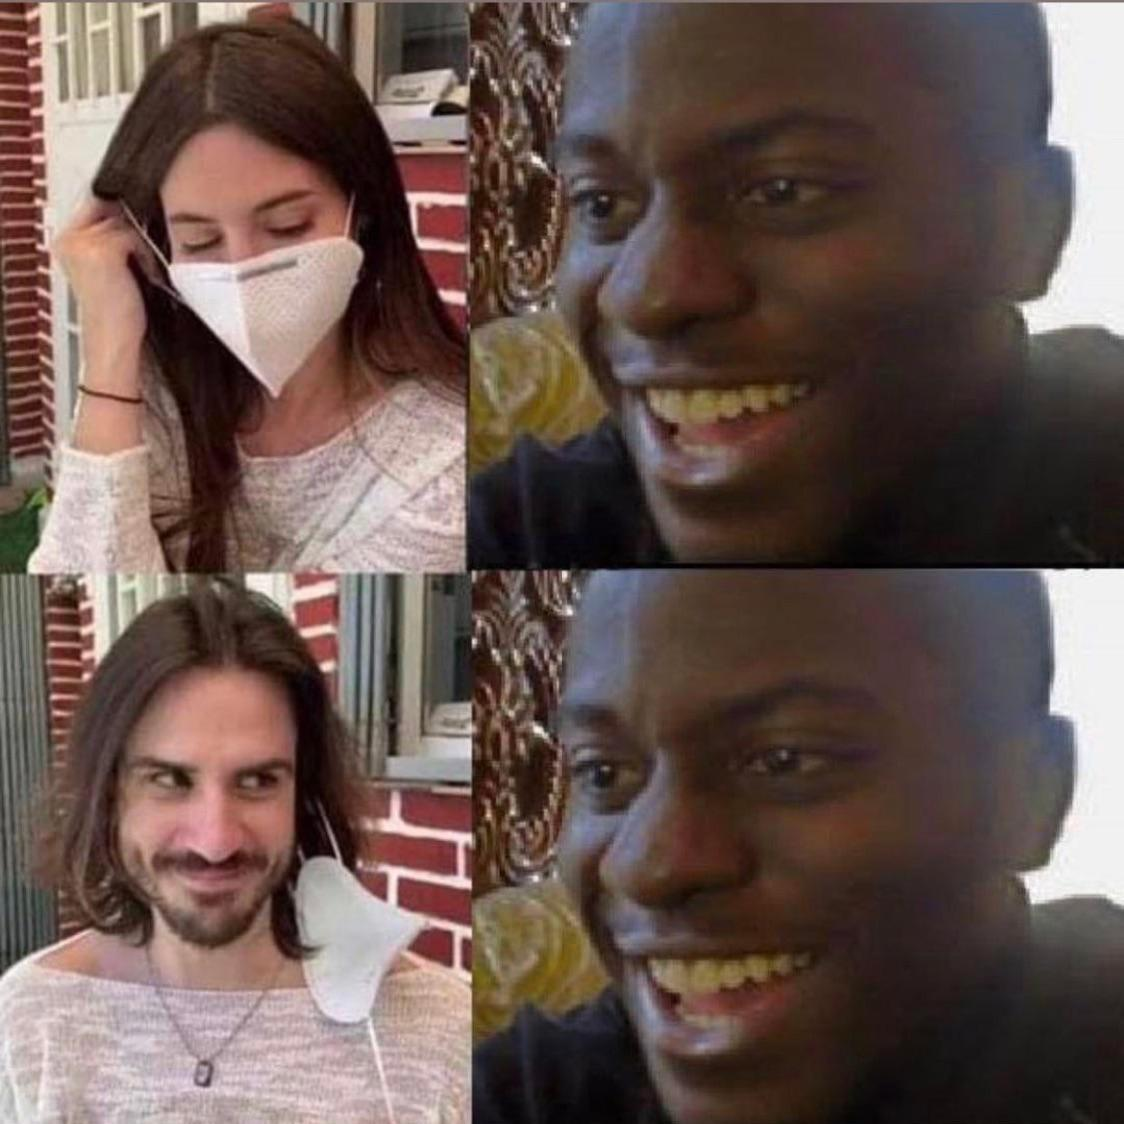

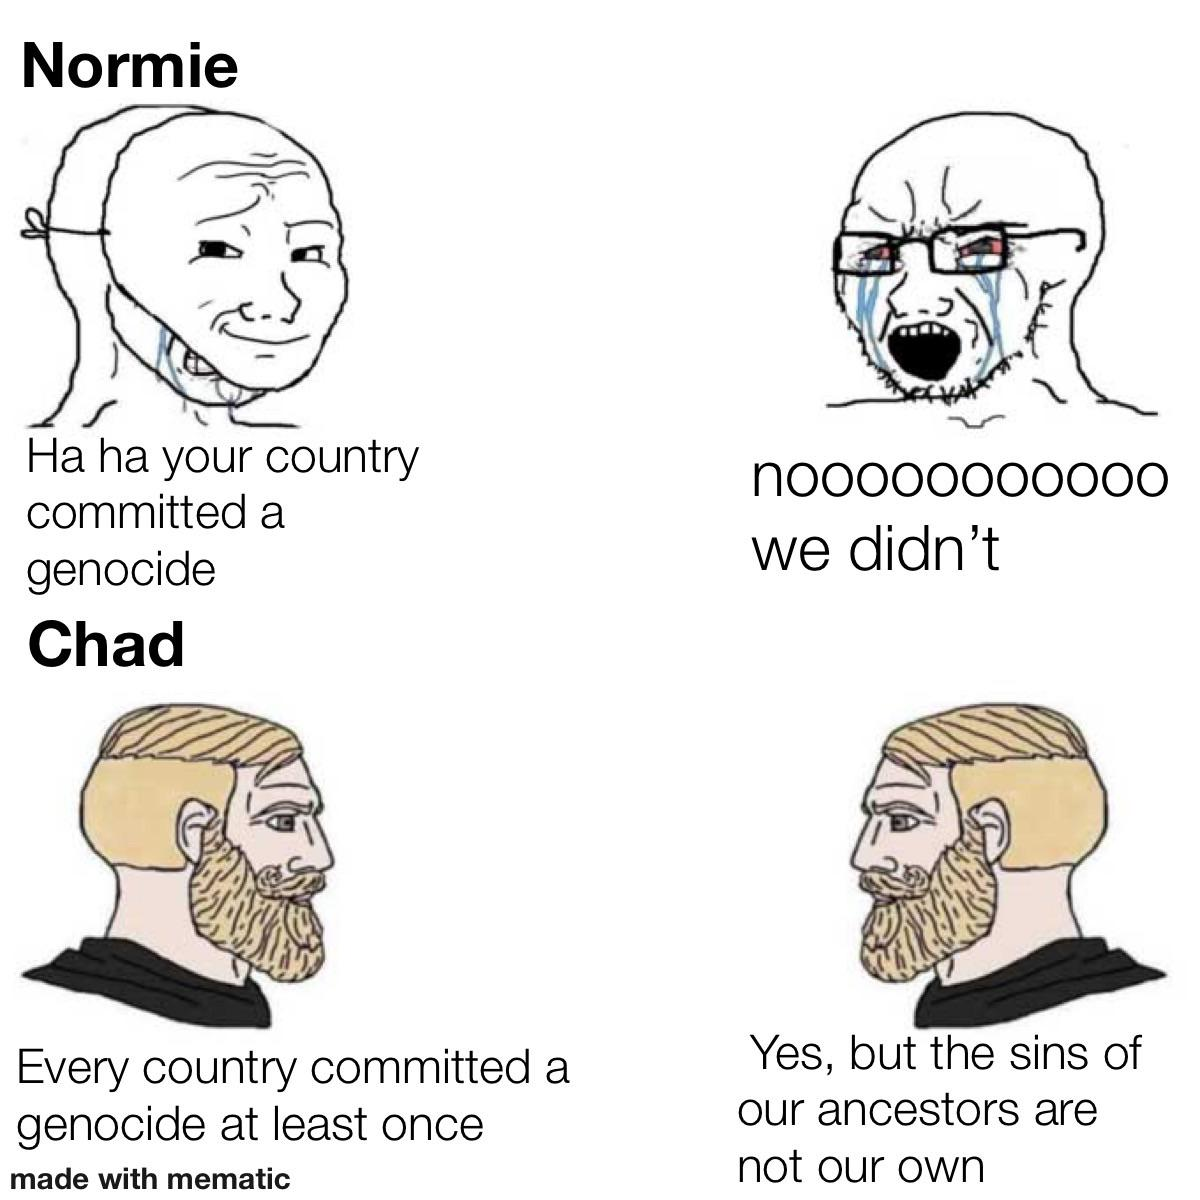

images/memes/klh7c2vga5l61.jpg
images/memes/1bli2b41n4l61.jpg


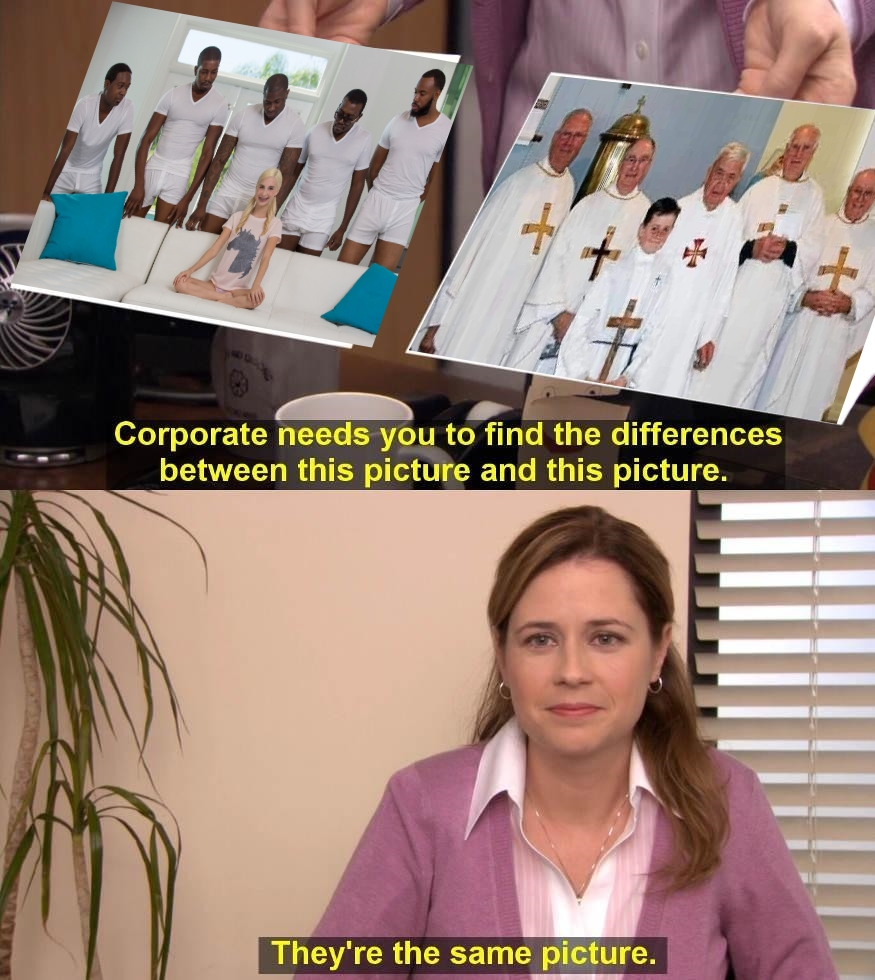

bottom 3
images/memes/5ifeayumb3l61.jpg


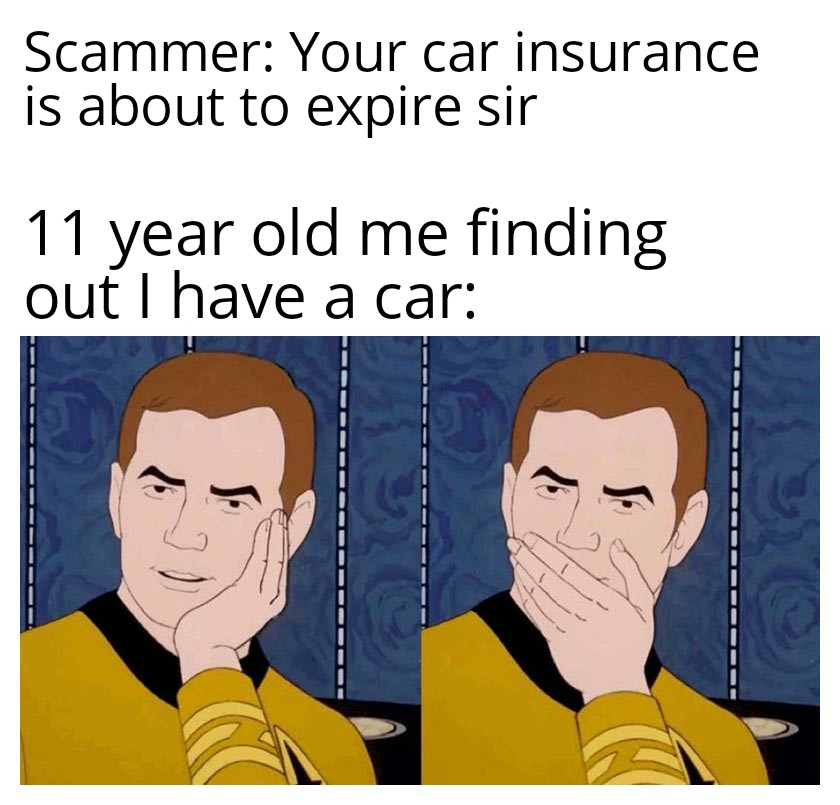

images/memes/mqnnoz7sr4l61.jpg


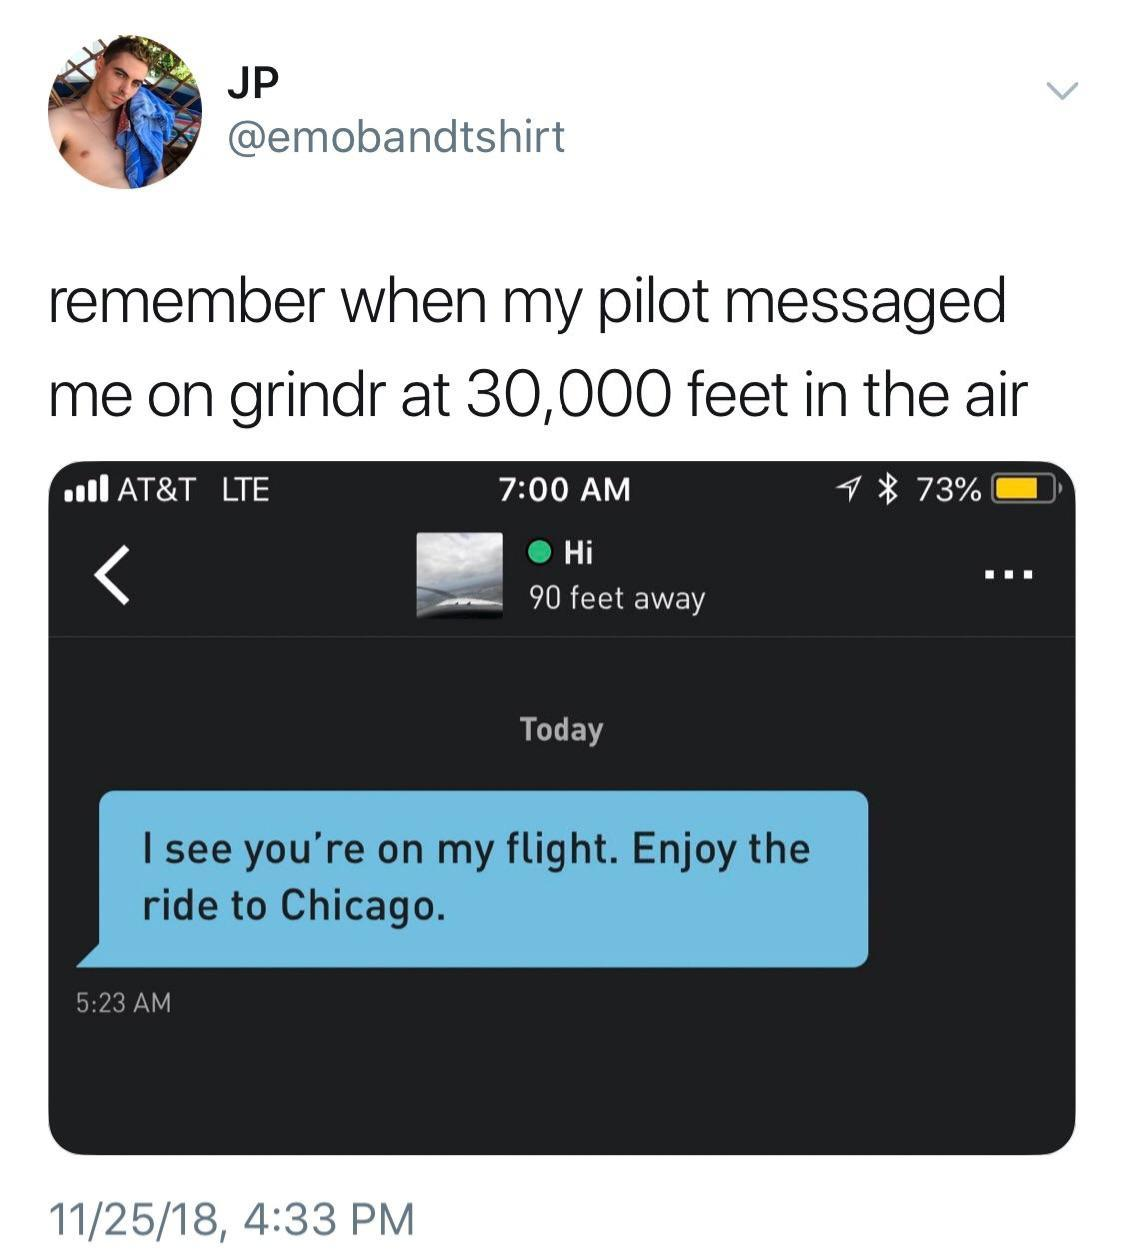

images/memes/l8ulu6ya23l61.jpg


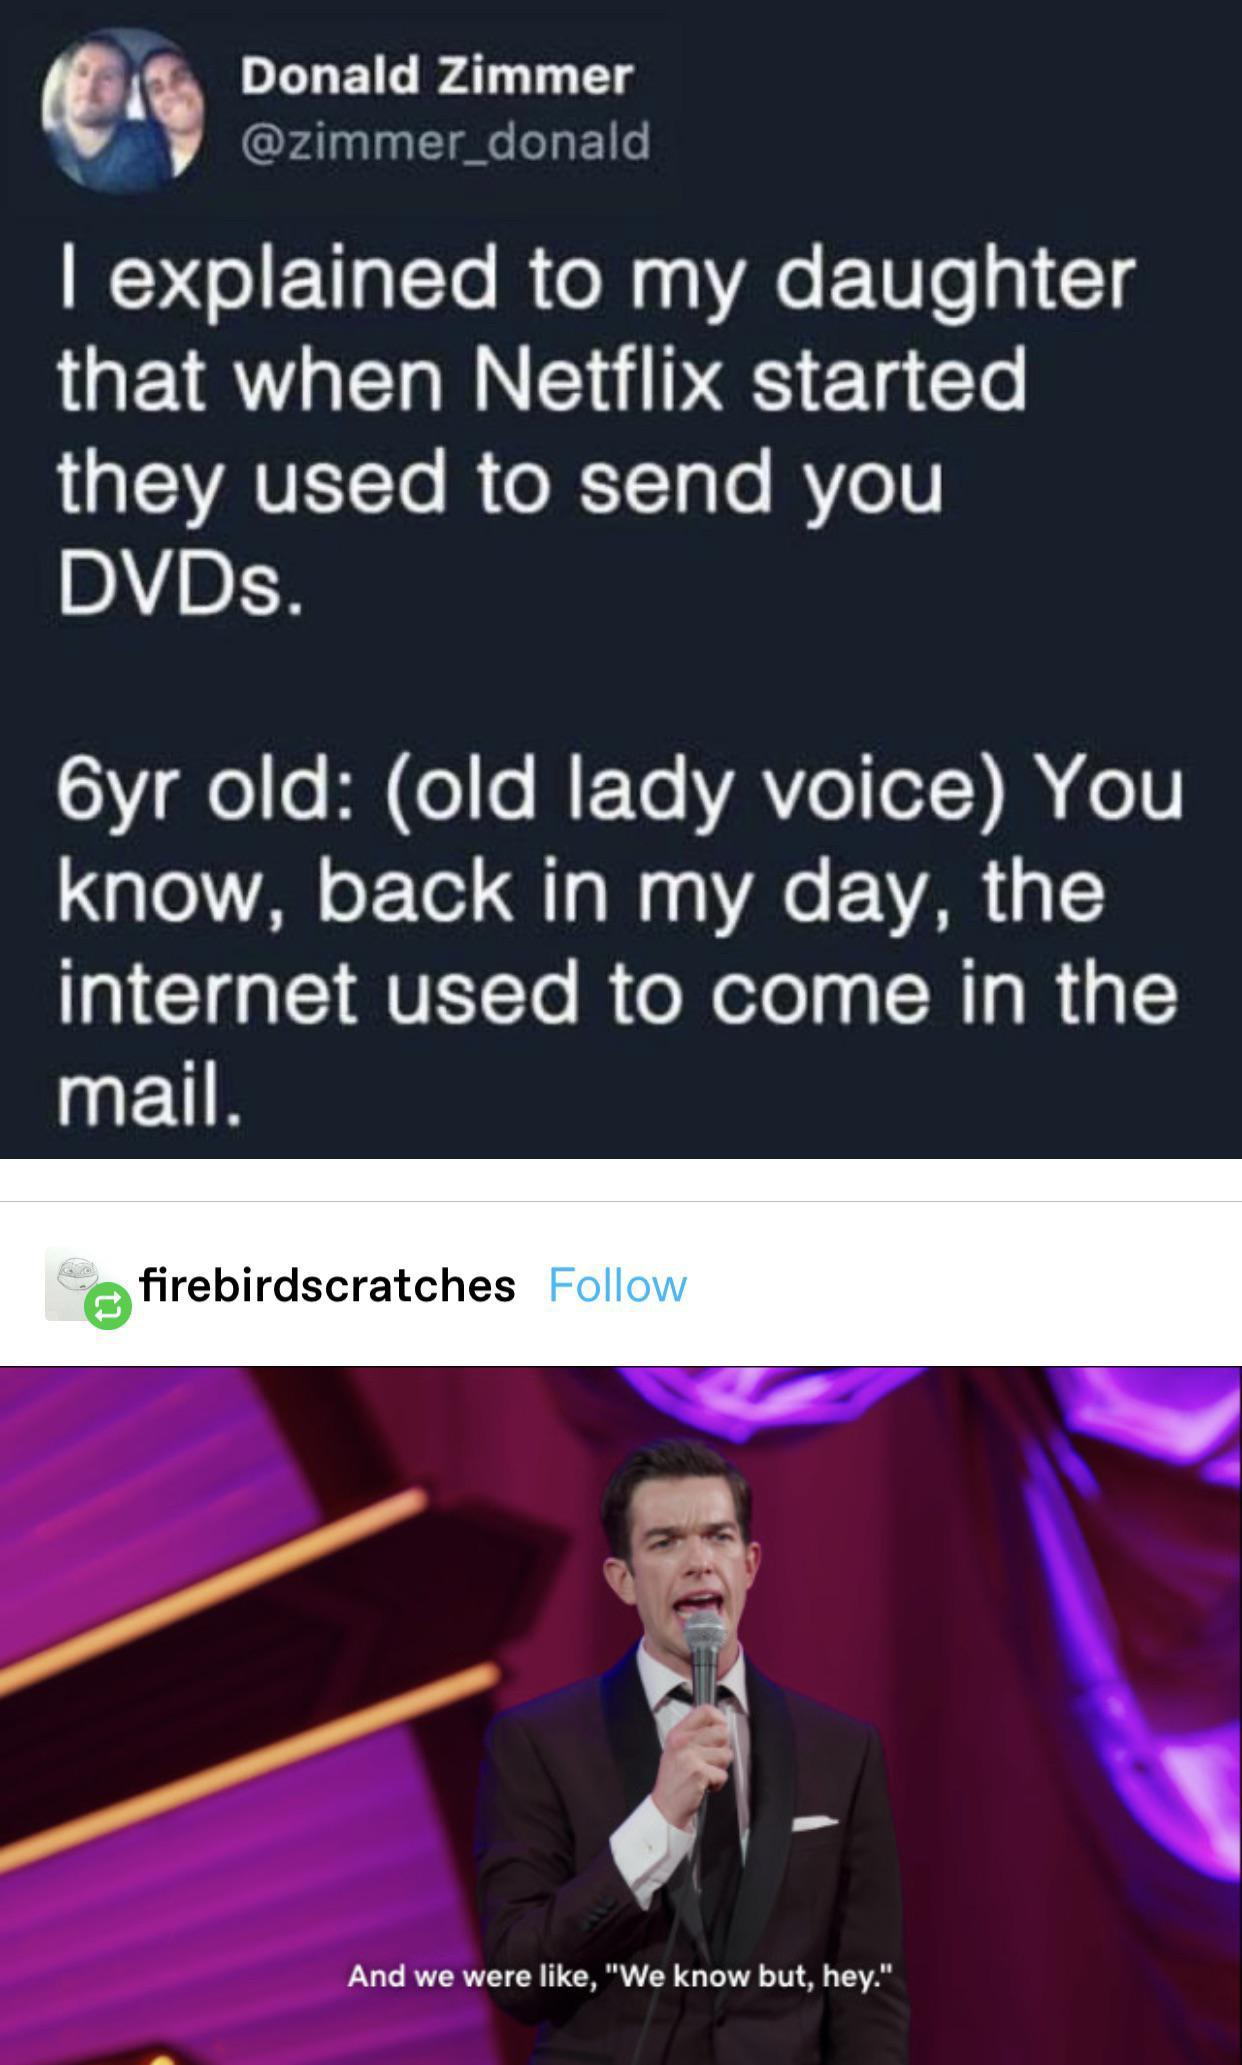

In [ ]:
n = 3
w = 200
print(f'top {n}')
printi([file for file, score in results], n, w)
print(f'bottom {n}')
printi([file for file, score in inv_results], n, w)

---

## Using Annoy for nn lookup

In [ ]:
from annoy import AnnoyIndex

In [ ]:
t = AnnoyIndex(512, 'angular')
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

for i, img in enumerate(image_features):
    t.add_item(i, img)

t.build(10)

True

In [ ]:
out_ann = path/'memery.ann'
t.save(str(out_ann))

True

In [ ]:
text = "a picture of a dog"
with torch.no_grad():
    text = clip.tokenize(text).to(device)
    text_features = model.encode_text(text)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)


In [ ]:
nn_indexes = t.get_nns_by_vector(text_features.t(), 10)

images/memes/vfcmqsrlm3l61.jpg


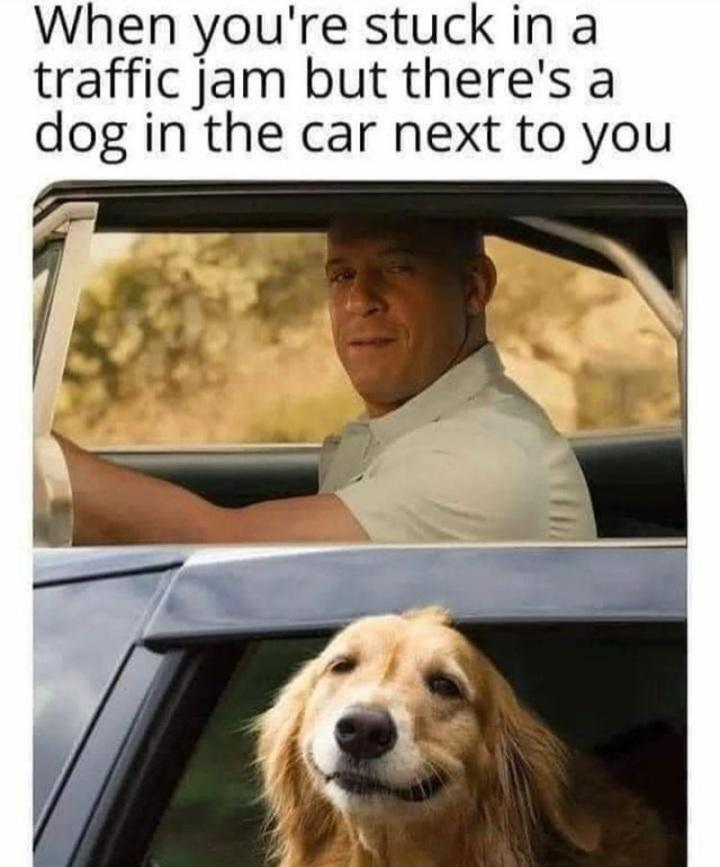

images/memes/z09icjl3t3l61.jpg


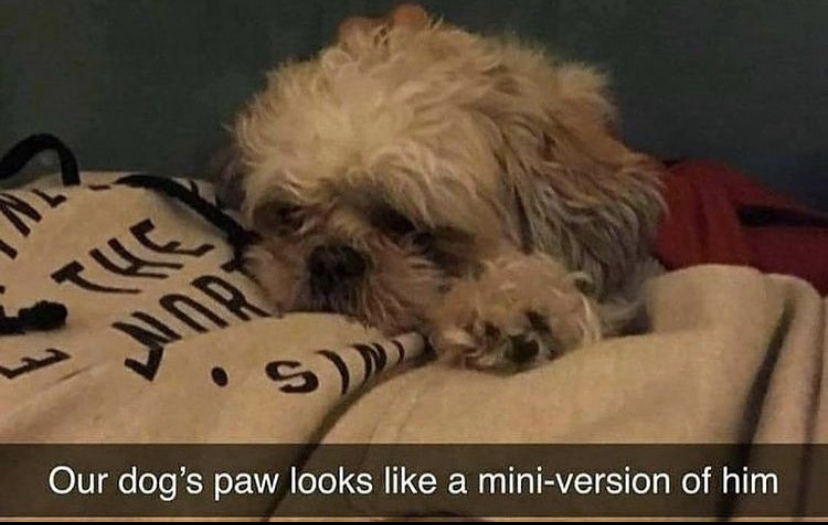

images/memes/9joytrabk5l61.jpg


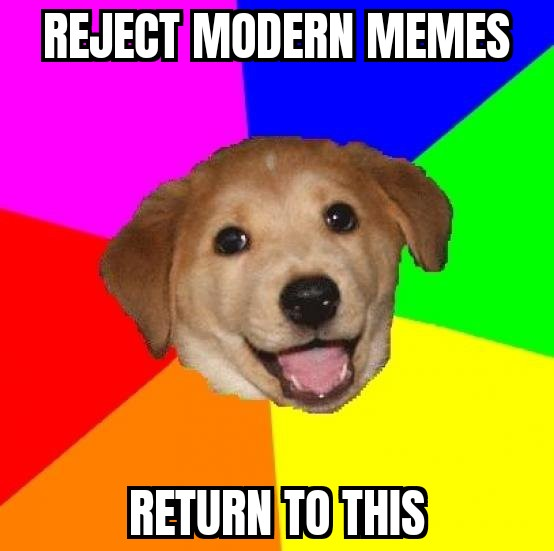

In [ ]:
printi([str(image_names[i]) for i in nn_indexes])

In [ ]:

t.get_n_items()

62

In [ ]:
namefile = path/'names.txt'

with open(str(namefile), 'w') as f:
    f.writelines([f'{str(o)}\n' for o in image_names])